cpu
cpu count: 4 

0.0
2.0
4.0
6.0
8.0
10.0
12.0


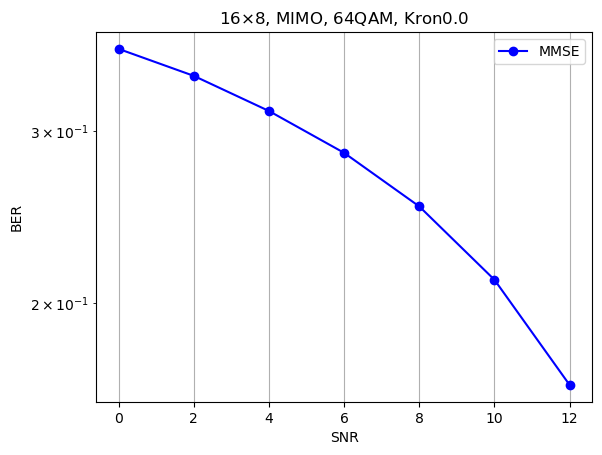

In [3]:
import time
import torch
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
from math import sqrt
from scipy.linalg import toeplitz
# Parameters Setting
TestDataLen = 30000
TxAntNum = 8   # Number of transmitting antennas
RxAntNum = 16   # Number of receiving antennas tested
DataLen  = 1    # Length of data sequence
MaxIter = 4     # Max iteration number of iterative algorithms
delta = 0.5     # Damping factor

# SNR setting
SNRdBLow = 0   # Minimal value of SNR in dB
SNRdBHigh = 12   # Maximal value of SNR in dB
SNRIterval = 2  # Interval value of SNR sequence
SNRNum = int((SNRdBHigh-SNRdBLow)/SNRIterval)+1   # Number of SNR sequence
SNRdB = np.linspace(SNRdBLow, SNRdBHigh, SNRNum)
TSratio = 0
RSratio = 0
Kron = np.sqrt(TSratio*RSratio)
# Constellation Setting
ModType = 8
if ModType==2:
    Model = '4QAM'
    Cons = torch.tensor([-1., 1.])
    fnorm = 1/np.sqrt(2)
    bitperSym = 1
    normCons = fnorm*Cons
elif ModType==4:
    Model = '16QAM'
    Cons = torch.tensor([-3., -1., 1., 3.])
    bitCons = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]])
    bitperSym = 2
    fnorm = 1/np.sqrt(10)
    normCons = fnorm*Cons
elif ModType==8:
    Model = '64QAM'
    Cons = torch.tensor([-7., -5., -3., -1., 1., 3., 5., 7.])
    bitCons = torch.tensor([[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]])
    bitperSym = 3
    fnorm = 1/np.sqrt(42)
    normCons = fnorm*Cons
elif ModType==16:
    Model = '256QAM'
    Cons = torch.tensor([-15., -13., -11., -9., -7., -5., -3., -1., 1., 3., 5., 7., 9., 11., 13., 15.])
    bitCons = torch.tensor([[0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 1], [0, 1, 0, 0], [0, 1, 0, 1], [0, 1, 1, 0], [0, 1, 1, 1],
                            [1, 0, 0, 0], [1, 0, 0, 1], [1, 0, 1, 0], [1, 0, 1, 1], [1, 1, 0, 0], [1, 1, 0, 1], [1, 1, 1, 0], [1, 1, 1, 1]])
    bitperSym = 4
    fnorm = 1/np.sqrt(170)
    normCons = fnorm*Cons

# Variable Initialization
error_MMSE = np.zeros(SNRNum)




# Correlation channel
def KronChannel(TxAntNum, RxAntNum, DataLen, TSratio, RSratio):
    # 1. Generate Rayleigh channel matrix
    Hiid = np.sqrt(1 / 2) * (torch.randn(DataLen, RxAntNum, TxAntNum) + 1j * torch.randn(DataLen, RxAntNum, TxAntNum))

    # 2. Generate the Transmit UpperMatrix
    indexT = torch.tensor(toeplitz(-torch.arange(TxAntNum), torch.arange(TxAntNum))).unsqueeze(dim=-3)
    randT = torch.rand([DataLen, 1, 1])
    phaseT = torch.exp(1j * randT * np.pi / 2 * indexT)
    ampT = TSratio ** torch.abs(indexT)
    Rt = ampT * phaseT
    Ct = torch.linalg.cholesky(Rt, upper=True)

    # 3. Generate the Receive UpperMatrix
    indexR = torch.tensor(toeplitz(-torch.arange(RxAntNum), torch.arange(RxAntNum))).unsqueeze(dim=-3)
    randR = torch.rand([DataLen, 1, 1])
    phaseR = torch.exp(1j * randR * np.pi / 2 * indexR)
    ampR = RSratio ** torch.abs(indexR)
    Rr = ampR * phaseR
    Cr = torch.linalg.cholesky(Rr, upper=True)

    Hkron = Cr.matmul(Hiid.matmul(Ct.conj().transpose(-1, -2)))

    return Hkron


# Generating Data Sent, Recived, Noise, and Transmitting Matrix
def GenerateTestData(SampleNum, TxAntNum, RxAntNum, DataLen, SNRdBLow, SNRdBHigh):
    x_ = torch.zeros([SampleNum, 2*TxAntNum, DataLen])
    y_ = torch.zeros([SampleNum, 2*RxAntNum, DataLen])
    H_ = torch.zeros([SampleNum, 2*RxAntNum, 2*TxAntNum])
    Nv_ = torch.zeros([SampleNum, 1, 1])
    H = KronChannel(TxAntNum, RxAntNum, SampleNum, TSratio, RSratio)
    for itr in range(SampleNum):
        RandSNRdB = np.random.uniform(low=SNRdBLow, high=SNRdBHigh)
        SNR = 10**(RandSNRdB/10)
        # Generate real and image part of data sequence seperately
        TxDataSyms = torch.randint(0, ModType, size=(2*TxAntNum, DataLen))
        # TxData_r, TxData_i = Modulation(TxDataBits, ModType, Cons)
        TxData_r = Cons[TxDataSyms[:TxAntNum, :]]
        TxData_i = Cons[TxDataSyms[TxAntNum:, :]]
        # Transform complex Tx signals to real
        TxData = torch.cat((TxData_r, TxData_i), dim=0)
        x_[itr, :, :] = TxData
        # TxSymbol = np.concatenate((TxPilot, TxData), 1)
        TxSymbol = TxData
        # Generate channel matrix (Rayleigh channel)
        # Hc = np.sqrt(1/2)*(torch.randn(RxAntNum, TxAntNum) + 1j*torch.randn(RxAntNum, TxAntNum))
        Hc = H[itr]
        # Transform complex channle matrix to real
        HMat = torch.cat((torch.cat((torch.real(Hc), -torch.imag(Hc)), 1),
                          torch.cat((torch.imag(Hc), torch.real(Hc)), 1)), 0).float()
        # Normalize the column of real channel matrix
        HMat /= np.sqrt(torch.norm(HMat)**2/(2*TxAntNum))
        # Data send via the channels without AWGN
        RxSymbol_noAWGN = torch.matmul(HMat, TxSymbol)
        # Calculate the norm of channel matrix
        Hnorm = torch.norm(HMat)**2
        # Noise variance & adding AWGN
        Nv = (1*Hnorm)/(2*SNR*(2*RxAntNum)*fnorm**2)
        RxSymbol = RxSymbol_noAWGN + np.sqrt(Nv)*torch.randn(2*RxAntNum, DataLen)
        Hhat = HMat
        y_[itr, :, :] = RxSymbol
        H_[itr, :, :] = Hhat
        Nv_[itr, :, :] = Nv


    return x_, y_, H_, Nv_

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


def MMSEtest(x, y, H, Nv):
    error_MMSE = 0

    HTy = H.transpose(-2, -1).matmul(y)
    HTH = H.transpose(-2, -1).matmul(H)

    # MIMO detection (MMSE) using perfect CSI
    Sigma = torch.inverse(HTH + Nv * fnorm ** 2 * torch.unsqueeze(torch.eye(2 * TxAntNum), 0))
    xhat = torch.matmul(Sigma, HTy)

    # calculation of BER
    _, indices = torch.min((xhat - Cons) ** 2, dim=-1, keepdim=True)
    _, indices_x = torch.min((x - Cons) ** 2, dim=-1, keepdim=True)
    Rxbit = bitCons[indices]
    xbit = bitCons[indices_x]
    comp = torch.where(
        Rxbit != xbit)  # return tuple (Tensor, Tensor, Tensor), where contains the 3D coordinates of non-zero elements
    error_MMSE += len(comp[0])

    return error_MMSE




if __name__ == "__main__":
    print("cpu count:", multiprocessing.cpu_count(), "\n")
    for nEN in range(SNRNum):
        print(SNRdB[nEN])

        for i in range (5):
            # we do this because the process of "GenerateTestData" sometimes uses
            # too much space, thus, we must need this loop to maintain the
            # number of TestDataLen

            x, y, H, Nv = GenerateTestData(TestDataLen, TxAntNum, RxAntNum,
                                           DataLen, SNRdB[nEN], SNRdB[nEN])

            error_MMSE[nEN] = MMSEtest(x, y, H, Nv)

        
    ber_MMSE = error_MMSE / (2 * TestDataLen * TxAntNum * bitperSym)


    plt.figure(1)
    # plt.style.use("_classic_test_patch")
    p1 = plt.semilogy(SNRdB, ber_MMSE, 'b-o', label='MMSE')
    plt.legend()
    plt.grid()
    plt.xlabel('SNR')
    plt.ylabel('BER')
    plt.title(str(RxAntNum) + r'$\times$' + str(TxAntNum) + ', MIMO, ' + str(Model) + ', Kron' +str(Kron))

    plt.show()